In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets, models
from collections import OrderedDict

import time
import math

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)


PROJECT_ROOT_DIR = '.'
DATASET_NAME = 'flower_data'
DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, 'datasets')
DATASET_PATH = os.path.join(DATASETS_PATH, DATASET_NAME)
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, 'pretained')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from shutil import copy, rmtree

def mk_file(file_path: str):
    if os.path.exists(file_path):
        rmtree(file_path)
    os.makedirs(file_path)

In [4]:
original_dataset = os.path.join(DATASET_PATH, "flower_photos")

assert os.path.exists(original_dataset)
flower_class = [cla for cla in os.listdir(original_dataset)
                    if os.path.isdir(os.path.join(original_dataset, cla))]
num_class = len(flower_class)
print("数据集类别：" , flower_class)

数据集类别： ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [5]:
# 建立保存训练集的文件夹
train_root = os.path.join(DATASET_PATH, "train")
mk_file(train_root)
for cla in flower_class:
    # 建立每个类别对应的文件夹
    mk_file(os.path.join(train_root, cla))
        
# 建立保存验证集的文件夹
val_root = os.path.join(DATASET_PATH, "val")
mk_file(val_root)
for cla in flower_class:
    # 建立每个类别对应的文件夹
    mk_file(os.path.join(val_root, cla))

In [6]:
import random

split_rate = 0.1

for cla in flower_class:
    cla_path = os.path.join(original_dataset, cla)
    images = os.listdir(cla_path)
    num = len(images)
    # 随机采样验证集的索引
    eval_index = random.sample(images, k=int(num*split_rate))
    for index, image in enumerate(images):
        if image in eval_index:
            # 将分配至验证集中的文件复制到相应目录
            image_path = os.path.join(cla_path, image)
            new_path = os.path.join(val_root, cla)
            copy(image_path, new_path)
        else:
            # 将分配至训练集中的文件复制到相应目录
            image_path = os.path.join(cla_path, image)
            new_path = os.path.join(train_root, cla)
            copy(image_path, new_path)
        print("\r[{}] 训练验证样本分离 [{}/{}]".format(cla, index+1, num), end="") 
    print()

[daisy] 训练验证样本分离 [633/633]
[dandelion] 训练验证样本分离 [898/898]
[roses] 训练验证样本分离 [641/641]
[sunflowers] 训练验证样本分离 [699/699]
[tulips] 训练验证样本分离 [799/799]


In [7]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [8]:
batch_size = 64

train_dataset = datasets.ImageFolder(root=train_root,
                                     transform=data_transform["train"])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=val_root,
                                    transform=data_transform["val"])

validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              4, shuffle=True,
                                              num_workers=0)

train_num = len(train_dataset)
val_num = len(validate_dataset)
print("训练样本数：" , train_num)
print("验证样本数：" , val_num)

训练样本数： 3306
验证样本数： 364


In [9]:
class InvertedResidual(nn.Module):
    def __init__(self,input_features,output_features,stride):
        super(InvertedResidual, self).__init__()
        branch_features = output_features//2
        self.stride = stride
        self.branch1 = nn.Sequential()
        if stride > 1:
            self.branch1 = nn.Sequential(
                nn.Conv2d(input_features, input_features, kernel_size=3, stride=stride, padding=1, bias=False, groups=input_features),
                nn.BatchNorm2d(input_features),
                nn.Conv2d(input_features, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(branch_features),
                nn.ReLU(inplace=True),
            )

        self.branch2 = nn.Sequential(
            nn.Conv2d(input_features if (stride > 1) else branch_features,branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True), 
            nn.Conv2d(branch_features, branch_features, kernel_size=3, stride=stride, padding=1, bias=False, groups=branch_features),
            nn.BatchNorm2d(branch_features),
            nn.Conv2d(branch_features, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
            )

    def forward(self, x):
        if self.stride == 1:
            x1, x2 = x.chunk(2, 1)
            out = torch.cat((x1, self.branch2(x2)), 1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), 1)

        out = channel_shuffle(out, 2)

        return out

In [10]:
def channel_shuffle(x, groups):
    N,C,H,W = x.size()
    return x.view(N,groups,int(C/groups),H,W).transpose(1,2).contiguous().view(N,-1,H,W)

In [11]:
class ShuffleNetV2(nn.Module):
    
    def __init__(self,num_classes=1000):
        super(ShuffleNetV2, self).__init__()
        
        self.input_channels = 24
    
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.input_channels, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.input_channels),
            nn.ReLU(inplace=True),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.stage2 = self._make_layer(116,4)
        self.stage3 = self._make_layer(232,8)
        self.stage4 = self._make_layer(464,4)

        self.conv5 = nn.Sequential(
            nn.Conv2d(self.input_channels, 1024, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(1024, num_classes)
        
    def _make_layer(self, output_channels,num_blocks):
        layers = []
        layers.append(InvertedResidual(self.input_channels,output_channels,2))
        for i in range(num_blocks-1):
            layers.append(InvertedResidual(output_channels,output_channels,1))
            self.input_channels = output_channels
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = x.mean([2, 3])
        x = self.fc(x)
        return x

In [12]:
net = ShuffleNetV2()

model_weights_path = os.path.join(MODEL_PATH, 'shufflenetv2_x1-5666bf0f80.pth')
missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_weights_path), strict=False)

In [13]:
for parma in net.parameters():
    parma.requires_grad = False    

net.fc = nn.Sequential(nn.Linear(1024, 64),
                     nn.ReLU(inplace=True),
                     nn.Dropout(p=0.5),
                     nn.Linear(64, 5)
                    )
net.to(device)

if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [14]:
from torchsummary import summary

summary(net, (3, 224, 224))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 58, 28, 28]           1,392
       BatchNorm2d-8           [-1, 58, 28, 28]             116
              ReLU-9           [-1, 58, 28, 28]               0
           Conv2d-10           [-1, 58, 56, 56]           1,392
      BatchNorm2d-11           [-1, 58, 56, 56]             116
             ReLU-12           [-1, 58, 56, 56]               0
           Conv2d-13           [-1, 58, 28, 28]             522
      BatchNorm2d-14           [-1, 58,

In [15]:
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    

    plt.axis("equal")
    ax = plt.gca() 
    left, right = plt.xlim()  
    ax.spines['left'].set_position(('data', left))
    ax.spines['right'].set_position(('data', right))
    for edge_i in ['top', 'bottom', 'right', 'left']:
        ax.spines[edge_i].set_edgecolor("white")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j]) if normalize else int(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if num > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

In [16]:
epoches = 30
lr = 0.1

criterion = nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4)

In [17]:
save_path = './generated/ShuffleNet.pth'
best_acc = 0.0
train_losses = []
train_accs = []
test_losses = []
test_accs =[]

In [18]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    t1 = time.perf_counter()
    for step, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rEpoch {}: {:^3.0f}%[{}->{}]{:.3f}".format(epoch+1, int(rate * 100), a, b, loss), end="")
    print('  Running time: %.3f' % (time.perf_counter() - t1))
    acc = 100.*correct/total
    loss = train_loss / step
    print('train loss: %.6f, acc: %.3f%% (%d/%d)' % (loss, acc, correct, total))
    return loss,acc/100

In [19]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for step, (inputs, targets) in enumerate(validate_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        val_accurate = correct / val_num
        global best_acc
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
    acc = 100.*correct/total
    loss = test_loss / step
    print('test loss: %.6f, acc: %.3f%% (%d/%d)' % (loss, acc, correct, total))
    return loss,acc/100

In [20]:
for epoch in range(epoches):
    train_loss,train_acc = train(epoch)
    test_loss,test_acc = test(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

Epoch 1: 100%[**************************************************->]1.530  Running time: 13.927
train loss: 1.605250, acc: 28.494% (942/3306)
test loss: 1.497173, acc: 53.022% (193/364)
Epoch 2: 100%[**************************************************->]0.954  Running time: 13.418
train loss: 1.274092, acc: 53.055% (1754/3306)
test loss: 0.850244, acc: 81.044% (295/364)
Epoch 3: 100%[**************************************************->]0.662  Running time: 13.774
train loss: 0.859617, acc: 69.964% (2313/3306)
test loss: 0.577460, acc: 83.516% (304/364)
Epoch 4: 100%[**************************************************->]0.700  Running time: 13.987
train loss: 0.703729, acc: 75.802% (2506/3306)
test loss: 0.427385, acc: 86.264% (314/364)
Epoch 5: 100%[**************************************************->]0.665  Running time: 13.937
train loss: 0.600572, acc: 79.734% (2636/3306)
test loss: 0.397746, acc: 87.088% (317/364)
Epoch 6: 100%[**************************************************->]0.60

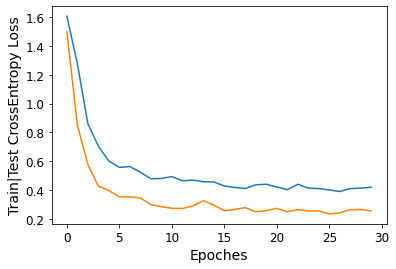

In [21]:
epoches = [x for x in range(epoches)]
plt.plot(epoches, train_losses, epoches, test_losses)
plt.xlabel('Epoches')
plt.ylabel('Train|Test CrossEntropy Loss')
plt.show()

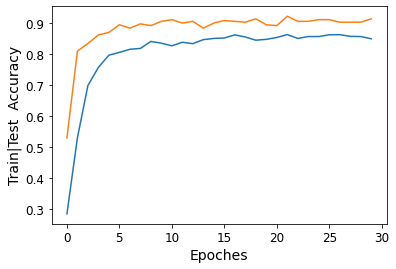

In [22]:
plt.plot(epoches, train_accs, epoches, test_accs)
plt.xlabel('Epoches')
plt.ylabel('Train|Test  Accuracy')
plt.show()

In [23]:
import itertools
import numpy as np

conf_matrix = torch.zeros(num_class, num_class)
correct = 0
total = 0
class_correct = list(0. for i in range(num_class))
class_total = list(0. for i in range(num_class))

with torch.no_grad():
    for data in validate_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        predict = torch.max(outputs, dim=1)[1]
        conf_matrix = confusion_matrix(predict, labels=labels, conf_matrix=conf_matrix)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        c = (predict == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        flower_class[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 91 %
Accuracy of daisy : 90 %
Accuracy of dandelion : 97 %
Accuracy of roses : 84 %
Accuracy of sunflowers : 95 %
Accuracy of tulips : 87 %


Confusion matrix, without normalization
[[57.  1.  1.  0.  1.]
 [ 4. 87.  0.  2.  3.]
 [ 0.  0. 54.  0.  5.]
 [ 0.  1.  1. 66.  1.]
 [ 2.  0.  8.  1. 69.]]


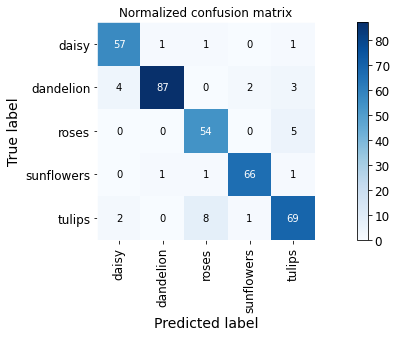

In [24]:
plot_confusion_matrix(conf_matrix.numpy(), classes=flower_class, normalize=False,
                                 title='Normalized confusion matrix')